<a href="https://colab.research.google.com/github/WhiteAndBlackFox/LearningPyTorch/blob/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks

Обучить генератор создавать точки, которые будут лежать на графике функции

**y = sin(x)/x - x/10**

При выполнении необходимо:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [1]:
import numpy as np

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
# Функция для вывода и сохранения изображения
def sample_image(static_sample, save_img = False):
    npimg = make_grid(static_sample.data[:25]).cpu().numpy()
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    if save_img:
        save_image(gen_imgs.data[:25], f"images/{batches_done}.png", nrow=5, normalize=True)

In [4]:
n_epochs = 200  # количество эпох
lr = 0.0002  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

latent_dim = 100  # Размерность случайного вектора, который подается на вход генератору

sample_interval = 50  # количество итераций для отображения процесса обучения

img_size = 128  # размер картинки, которую мы будет подавать в нейронные сети
channels = 1  # количество каналов в нашей картинке
batch_size = 16  # размер батча
img_shape = (channels, img_size, img_size)  # полный шейп нашей картинки

real_data = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ]),
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=8
)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 256, normalize=False),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
        )

    def forward(self, z):
        # sin(x)/x - x/10
        img = self.model(z)
        # img_1 = torch.div(torch.sin(img), img)
        # img = torch.abs(torch.sub(img_1, torch.div(img, 10)))
        img = torch.tanh(img)
        return img.reshape(-1, *img_shape)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = img.reshape(img.size(0), -1)
        return self.model(img)
        # img_1 = torch.div(torch.sin(img), img)
        # img = torch.eq(img_1, torch.div(img, 10))
        # return img.reshape(-1, *img_shape)

In [7]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 199/200] [Batch 3700/3750]|[D loss: 0.6925653219223022] [G loss: 0.8339290618896484]


<Figure size 432x288 with 0 Axes>

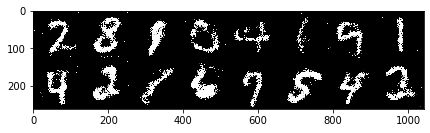

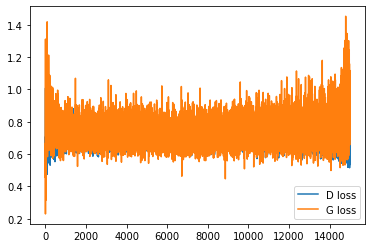

In [8]:
d_loss_history = []
g_loss_history = []
fig = plt.figure()

print("Starting Training Loop...")
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(real_data):
        ##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(z)
        # gen_imgs = torch.abs(torch.sub(torch.div(torch.sin(gen_imgs), gen_imgs), torch.div(gen_imgs, 10)))

        ######################  Тренировка дискриминатора    ##########################

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_imgs)

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        ######################  Тренировка генератора    ##########################

        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)

        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(z)
        # gen_imgs = torch.abs(torch.sub(torch.div(torch.sin(gen_imgs), gen_imgs), torch.div(gen_imgs, 10)))

        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_imgs)

        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)

        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()


        ######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i

        if batches_done % sample_interval == 0 or i == len(real_data):
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_image(gen_imgs)
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(real_data)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]')

                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()